# 轮廓特征

### 目标

在本文中，我们将学习
- 如何找到轮廓的不同特征，例如面积，周长，质心，边界框等。
- 您将看到大量与轮廓有关的功能。

### 1. 特征矩

特征矩可以帮助您计算一些特征，例如物体的质心，物体的面积等。请查看特征矩上的维基百科页面。函数**cv.moments**()提供了所有计算出的矩值的字典。见下文：

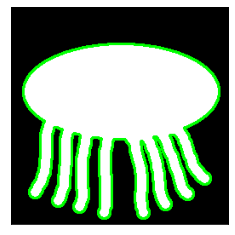

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

# img = cv.imread('data/pic3.png')

# imgray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# ret,thresh = cv.threshold(imgray,200,255,cv.THRESH_BINARY_INV)

org = cv.imread('data/9.png', 0)

ret,thresh = cv.threshold(org,127,255,cv.THRESH_BINARY)

contours,hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

img = cv.cvtColor(org, cv.COLOR_GRAY2BGR)
cv.drawContours(img, contours, 0, (0,255,0), 2)

plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.xticks([]), plt.yticks([])

plt.show()

In [2]:
cnt = contours[0]
M = cv.moments(cnt)
print( M )

{'m00': 29982.0, 'm10': 3828123.1666666665, 'm01': 3891914.1666666665, 'm20': 589395250.5, 'm11': 494568252.8333333, 'm02': 583122878.8333333, 'm30': 100912893359.65001, 'm21': 75887633374.43333, 'm12': 73747476931.13333, 'm03': 97528017673.55, 'mu20': 100617751.361516, 'mu11': -2354126.730900526, 'mu02': 77919894.35262173, 'mu30': -35405709.53166199, 'mu21': -19642692.384744644, 'mu12': -94897931.35087776, 'mu03': 1604487741.218048, 'nu20': 0.11193177935257809, 'nu11': -0.002618838030522187, 'nu02': 0.08668164716300455, 'nu30': -0.0002274687821911557, 'nu21': -0.00012619714093620125, 'nu12': -0.0006096846289025852, 'nu03': 0.010308249075170431}


从这一刻起，您可以提取有用的数据，例如面积，质心等。质心由关系给出，$C_x = \frac{M_{10}}{M_{00}}$ 和 $C_y = \frac{M_{01}}{M_{00}}$。可以按照以下步骤进行： 

In [3]:
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])

print(cx, ",", cy)

127 , 129


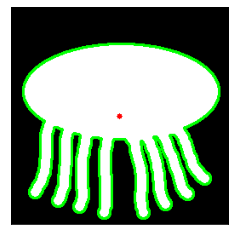

In [4]:
cv.circle(img, (cx, cy), 3, (0, 0, 255), -1)

plt.figure(figsize=(4, 4))
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])

plt.show()

### 2. 轮廓面积

轮廓区域由函数**cv.contourArea**()或从矩`M['m00']`中给出。

In [5]:
area = cv.contourArea(cnt) 
print(area)

29982.0


### 3. 轮廓周长

也称为弧长。可以使用**cv.arcLength**()函数找到它。第二个参数指定形状是闭合轮廓(`True`)还是曲线。

In [6]:
perimeter = cv.arcLength(cnt,True)
print(perimeter)

1984.9646356105804


### 4. 轮廓近似

根据我们指定的精度，它可以将轮廓形状近似为顶点数量较少的其他形状。它是Douglas-Peucker算法的实现。检查维基百科页面上的算法和演示。

为了理解这一点，假设您试图在图像中找到一个正方形，但是由于图像中的某些问题，您没有得到一个完美的正方形，而是一个“坏形状”（如下图所示）。现在，您可以使用此功能来近似形状。在这种情况下，第二个参数称为epsilon，它是从轮廓到近似轮廓的最大距离。它是一个精度参数。需要正确选择epsilon才能获得正确的输出。

下面，在图片中，绿线显示了ε=弧长的1％时的近似曲线。红线显示了ε=弧长度的4％时的情况。第三个参数指定曲线是否闭合。

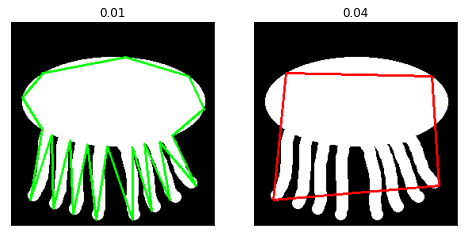

In [7]:
epsilon1 = 0.01*cv.arcLength(cnt,True) 
approx1 = cv.approxPolyDP(cnt,epsilon1,True)

epsilon2 = 0.04*cv.arcLength(cnt,True) 
approx2 = cv.approxPolyDP(cnt,epsilon2,True)

img1 = cv.cvtColor(org, cv.COLOR_GRAY2BGR)
img2 = cv.cvtColor(org, cv.COLOR_GRAY2BGR)

cv.drawContours(img1, [approx1], 0, (0,255,0), 2)
cv.drawContours(img2, [approx2], 0, (255,0,0), 2)

plt.figure(figsize=(8, 4))

plt.subplot(121),plt.imshow(img1)
plt.title('0.01'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img2)
plt.title('0.04'), plt.xticks([]), plt.yticks([])

plt.show()

### 5. 轮廓凸包

凸包外观看起来与轮廓逼近相似，但不相似（在某些情况下两者可能提供相同的结果）。在这里，**cv.convexHull**()函数检查曲线是否存在凸凹缺陷并对其进行校正。一般而言，凸曲线是始终凸出或至少平坦的曲线。如果在内部凸出，则称为凸度缺陷。例如，检查下面的手的图像。红线显示手的凸包。双向箭头标记显示凸度缺陷，这是凸包与轮廓线之间的局部最大偏差。

关于它的语法，有一些需要讨论：

```python
hull = cv.convexHull(points[, hull[, clockwise[, returnPoints]] 
```

参数详细信息：
- **点**是我们传递到的轮廓。
- **凸包**是输出，通常我们忽略它。
- **顺时针方向**：方向标记。如果为True，则输出凸包为顺时针方向。否则，其方向为逆时针方向。
- **returnPoints**：默认情况下为True。然后返回凸包的坐标。如果为False，则返回与凸包点相对应的轮廓点的索引。

因此，要获得如上图所示的凸包，以下内容就足够了：

```python
hull = cv.convexHull(cnt) 
```

但是，如果要查找凸度缺陷，则需要传递`returnPoints = False`。为了理解它，我们将拍摄上面的矩形图像。首先，我发现它的轮廓为`cnt`。现在，我发现它的带有`returnPoints = True`的凸包，得到以下值：`[[[234 202]]，[[51 202]]，[[51 79]]，[[234 79]]]`，它们是四个角 矩形的点。现在，如果对`returnPoints = False`执行相同的操作，则会得到以下结果：`[[129]，[67]，[0]，[142]]`。这些是轮廓中相应点的索引。例如，检查第一个值：`cnt [129] = [[234，202]]`与第一个结果相同（对于其他结果依此类推）。

当我们讨论凸度缺陷时，您将再次看到它。

### 6. 检查凸度

**cv.isContourConvex**()具有检查曲线是否凸出的功能。它只是返回True还是False。没什么大不了的。

In [8]:
hull = cv.convexHull(cnt)

k = cv.isContourConvex(cnt)

print(k)

False


### 7. 边界矩形

有两种类型的边界矩形。

#### 7.a.直角矩形

它是一个矩形，不考虑物体的旋转。所以边界矩形的面积不是最小的。它是由函数**cv.boundingRect**()找到的。

令`(x，y)`为矩形的左上角坐标，而`(w，h)`为矩形的宽度和高度。

```python
x,y,w,h = cv.boundingRect(cnt)
cv.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
```

#### 7.b. 旋转矩形

这里，边界矩形是用最小面积绘制的，所以它也考虑了旋转。使用的函数是**cv.minAreaRect**()。它返回一个Box2D结构，其中包含以下细节 -(中心(x,y)，(宽度，高度)，旋转角度)。但要画出这个矩形，我们需要矩形的四个角。它由函数**cv.boxPoints**()获得

```python
rect = cv.minAreaRect(cnt)
box = cv.boxPoints(rect)
box = np.int0(box)
cv.drawContours(img,[box],0,(0,0,255),2)
```

两个矩形都显示在一张单独的图像中。绿色矩形显示正常的边界矩形。红色矩形是旋转后的矩形。

![](data/boundingrect.png)

### 8. 最小闭合圈
接下来，使用函数**cv.minEnclosingCircle(*()查找对象的圆周。它是一个以最小面积完全覆盖物体的圆。

```python
(x,y),radius = cv.minEnclosingCircle(cnt)
center = (int(x),int(y))
radius = int(radius)
cv.circle(img,center,radius,(0,255,0),2)
```

![](data/circumcircle.png)

### 9. 拟合一个椭圆

下一个是把一个椭圆拟合到一个物体上。它返回内接椭圆的旋转矩形。

```python
ellipse = cv.fitEllipse(cnt)
cv.ellipse(img,ellipse,(0,255,0),2)
```

![](data/fitellipse.png)

### 10. 拟合直线

同样，我们可以将一条直线拟合到一组点。下图包含一组白点。我们可以近似一条直线。

```python
rows,cols = img.shape[:2]
[vx,vy,x,y] = cv.fitLine(cnt, cv.DIST_L2,0,0.01,0.01)
lefty = int((-x*vy/vx) + y)
righty = int(((cols-x)*vy/vx)+y)
cv.line(img,(cols-1,righty),(0,lefty),(0,255,0),2)
```

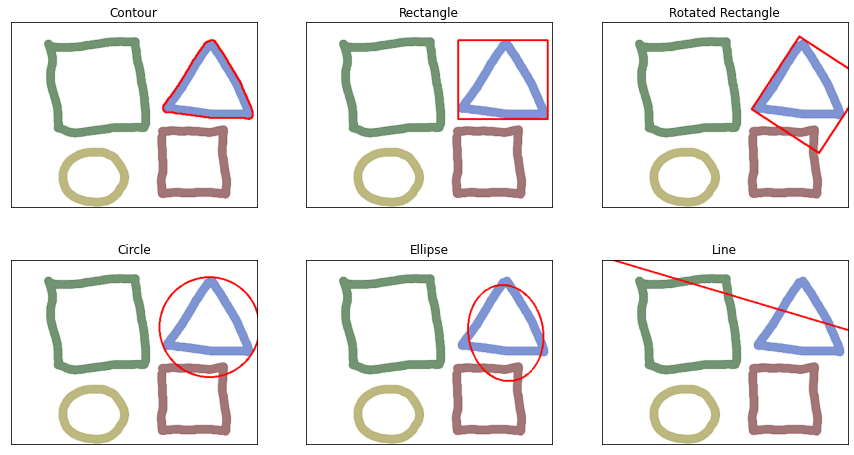

In [9]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

img = cv.imread('data/pic3.png')

imgray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
ret,thresh = cv.threshold(imgray,200,255,cv.THRESH_BINARY_INV)

contours,hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# 三角形轮廓线
img1 = img.copy()
cnt = contours[2]
cv.drawContours(img1, [cnt], 0, (255, 0, 0), 2)

# 直角矩形
img2 = img.copy()
rect = cv.boundingRect(cnt)
cv.rectangle(img2, rect, (255, 0, 0), 2)

# 旋转矩形
img3 = img.copy()
rect = cv.minAreaRect(cnt)
box = cv.boxPoints(rect)
box = np.intp(box)
cv.drawContours(img3,[box],0,(255, 0, 0),2)

# 最小闭合圈
img4 = img.copy()
(x,y),radius = cv.minEnclosingCircle(cnt)
center = (int(x),int(y))
radius = int(radius)
cv.circle(img4,center,radius,(255, 0, 0),2)

# 拟合一个椭圆
img5 = img.copy()
ellipse = cv.fitEllipse(cnt)
cv.ellipse(img5,ellipse,(255, 0, 0),2)

# 拟合直线
img6 = img.copy()
rows,cols = img6.shape[:2]
[vx,vy,x,y] = cv.fitLine(cnt, cv.DIST_L2,0,0.01,0.01)
lefty = int((-x*vy/vx) + y)
righty = int(((cols-x)*vy/vx)+y)
cv.line(img6,(cols-1,righty),(0,lefty),(255, 0, 0),2)


plt.figure(figsize=(15, 8))

plt.subplot(2,3,1),plt.imshow(img1)
plt.title('Contour'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2),plt.imshow(img2)
plt.title('Rectangle'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,3),plt.imshow(img3)
plt.title('Rotated Rectangle'), plt.xticks([]), plt.yticks([])

plt.subplot(2,3,4),plt.imshow(img4)
plt.title('Circle'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,5),plt.imshow(img5)
plt.title('Ellipse'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,6),plt.imshow(img6)
plt.title('Line'), plt.xticks([]), plt.yticks([])

plt.show()

### 附加资源

### 练习